In [20]:
import tensorflow as tf
import os

from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.utils import to_categorical

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

In [21]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

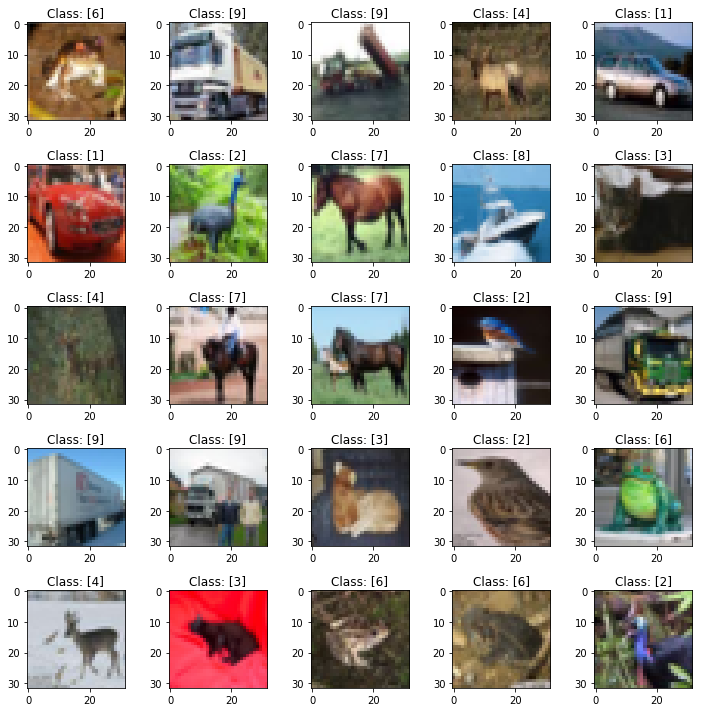

In [23]:
plt.figure(figsize=(10,10))
for idx in range(25):
    plt.subplot(5, 5, idx+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class: {}'.format(y_train[idx]))
    
plt.tight_layout()

In [24]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

num_channels = 3
X_train = X_train.reshape(-1, img_rows, img_cols, num_channels)
X_test = X_test.reshape(-1, img_rows, img_cols, num_channels)

input_shape = (img_rows, img_cols, num_channels)

X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [25]:
if np.max(X_train) > 1: X_train = X_train / 255
if np.max(X_test) > 1: X_test = X_test / 255

In [26]:
if len(y_train.shape) == 2:
    y_train = y_train.reshape(-1)
    y_test = y_test.reshape(-1)

if len(y_train.shape) == 1:
    num_classes = len(set(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

In [27]:
y_train.shape, y_test.shape, num_classes

((50000, 10), (10000, 10), 10)

In [28]:
 model = Sequential([
     Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
     Conv2D(64, kernel_size=(3, 3), activation='relu'),
     MaxPool2D(pool_size=(2, 2)),
     Dropout(0.25),
     
     Conv2D(64, kernel_size=(3, 3), activation='relu'),
     Conv2D(64, kernel_size=(3, 3), activation='relu'),
     MaxPool2D(pool_size=(2, 2)),
     Dropout(0.25),
     
     Conv2D(128, kernel_size=(3, 3), activation='relu'),
     MaxPool2D(pool_size=(2, 2)),
     Dropout(0.25),
     
     Flatten(), #<= bridge between conv layers and full connected layers
     
     Dense(1024, activation='relu'),
     Dropout(0.5),
     Dense(num_classes, activation='softmax')
     
 ])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
__________

TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
model, strategy=tf.contrib.tpu.TPUDistributionStrategy(
    tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

In [29]:
model.fit(X_train, y_train,
         epochs=20,
         batch_size=128 * 8,
         validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 179s 4ms/sample - loss: 2.1560 - acc: 0.1802 - val_loss: 2.0397 - val_acc: 0.2379
Epoch 2/20
40000/40000 [==============================] - 150s 4ms/sample - loss: 1.9104 - acc: 0.2720 - val_loss: 1.7845 - val_acc: 0.3289
Epoch 3/20
40000/40000 [==============================] - 152s 4ms/sample - loss: 1.7200 - acc: 0.3517 - val_loss: 1.6301 - val_acc: 0.4032
Epoch 4/20
40000/40000 [==============================] - 156s 4ms/sample - loss: 1.5959 - acc: 0.4062 - val_loss: 1.4979 - val_acc: 0.4539
Epoch 5/20
40000/40000 [==============================] - 172s 4ms/sample - loss: 1.4873 - acc: 0.4498 - val_loss: 1.4970 - val_acc: 0.4542
Epoch 6/20
40000/40000 [==============================] - 372s 9ms/sample - loss: 1.4248 - acc: 0.4810 - val_loss: 1.3932 - val_acc: 0.4900
Epoch 7/20
40000/40000 [==============================] - 391s 10ms/sample - loss: 1.3613 - acc: 0.5052 - val_

In [30]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 17s 2ms/sample - loss: 0.9561 - acc: 0.6628


[0.9560778595924377, 0.6628]